# Imports and Initialization


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import random
import torch.optim as optim
from google.colab import drive
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
!pip install mido
import mido
!pip install pretty_midi
import pretty_midi as pm
drive.mount("/drive")
!pip install librosa
import librosa
!pip install pypianoroll
import pypianoroll
import numpy as np
import sys
import os

np.set_printoptions(threshold=sys.maxsize)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 1.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=21a5623b64fe83c7d287f8458b02769ae53af85112aabc77e77c4a54d64b57e4
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
Successfully built pretty_midi
Mounted at /drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
torch.set_printoptions(threshold=10000)

# Data Loading and Pre Processing

In [ ]:
data = []

data = os.listdir("/drive/My Drive/nottingham")
print(len(data))

1022


In [ ]:
def shrink_matrix(matrix):
    new_matrix = np.empty((0, matrix.shape[1]), matrix.dtype)

    for i, row in enumerate(matrix):

        # Check if the current row index is divisible by 120
        if i % 6 == 0:

            # If it is, append the row to the new matrix
            new_matrix = np.vstack((new_matrix, row))
    return new_matrix

In [ ]:
def shrink_matrix_o(matrix):
    new_matrix = np.empty((0, matrix.shape[1]), matrix.dtype)

    for i, row in enumerate(matrix):

        # Check if the current row index is divisible by 120
        if i % 24 == 0:

            # If it is, append the row to the new matrix
            new_matrix = np.vstack((new_matrix, row))
    return new_matrix

In [ ]:
def pad_matrix(matrix):
  new_matrix = np.empty((0, matrix.shape[1]), np.float32)

  for row in matrix:
    for i in range(6):
      new_matrix = np.vstack((new_matrix, row))
  return new_matrix

In [ ]:
def pad_matrix_o(matrix):
  new_matrix = np.empty((0, matrix.shape[1]), matrix.dtype)

  for row in matrix:
    for i in range(24):
      new_matrix = np.vstack((new_matrix, row))
  return new_matrix

In [ ]:
def filter_notes(matrix):
    # Get the number of rows in the matrix
    num_rows = matrix.shape[0]
    
    # Create a new matrix filled with zeros to store the output
    output_matrix = np.zeros_like(matrix)
    
    # Loop over each row of the input matrix
    for i in range(num_rows):
        # Get the current row of the matrix
        row = matrix[i, :]
        
        # Find the indices of the 3 largest values in the row
        indices = np.argpartition(row, -3)[-3:]
        
        # Set all elements in the row to 0 except for the 3 largest values
        row[row < row[indices].min()] = 0
        
        # Assign the modified row to the corresponding row in the output matrix
        output_matrix[i, :] = row
    
    return output_matrix


#m = np.array([[0, 5, 8, 2, 1], [9, 8, 7, 4, 10], [6, 5, 5, 3, 4]])
#print(filter_notes(m))



In [ ]:
def find_key(mid):
    for msg in mid.tracks[0]:
        if msg.is_meta and msg.type == 'key_signature':
            return msg.key

In [ ]:
#DATA PROCESSING
tempo = []
input = []
output = []
name = []
keys = []

for path in data:
    midi = pypianoroll.read('/drive/My Drive/nottingham/' + path)
    mid = mido.MidiFile('/drive/My Drive/nottingham/' + path, clip=True)
    #print(vocal)
    vocal = midi.tracks[0]
    piano = midi.tracks[1]
    vocal.binarize()
    vocalpr = shrink_matrix(vocal.pianoroll[:,22:110])
    piano.binarize()
    pianopr = shrink_matrix_o(piano.pianoroll[:,22:110])
    for i in range(len(vocalpr) // 64):
      new_matrix = vocalpr[i*64:(i+1)*64,:]/80
      input.append(new_matrix)
      new_matrix = pianopr[i*16:(i+1)*16, :]/80
      output.append(new_matrix)
      tempo.append(midi.tempo)
      name.append(path + str(i))
      keys.append(find_key(mid))

/usr/local/lib/python3.9/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split
input = np.array(input)
output = np.array(output)
name = np.array(name)
tempo = np.array(tempo)
keys = np.array(keys)
input , input_test , output , output_test , name , name_test , tempo , tempo_test , keys , keys_test = train_test_split(input , output, name , tempo ,keys , test_size=0.2, random_state=10)

print(input.shape)


input = input[:,np.newaxis , :]
input_test= input_test[:,np.newaxis , :]
input_test = torch.Tensor(input_test)
print(output.shape)
output = output[:, np.newaxis,:]

input = torch.Tensor(input)
output = torch.Tensor(output)
print(output.shape)

input_dataset = TensorDataset(input)
output_dataset = TensorDataset(output)



#print(input_dataset.tensors)

dataloader = DataLoader(dataset = output_dataset , batch_size= 500)
dataloaderG = DataLoader(input_dataset, batch_size= 500 )

<ipython-input-11-99634fb6b6ff>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tempo = np.array(tempo)


(5894, 64, 88)
(5894, 16, 88)
torch.Size([5894, 1, 16, 88])


# GAN Model 


In [2]:


manualSeed = 3085
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


batchsize = 32
inputsize = 4
smallest_note =16
note_range = 129
epochs = 100
rate = 0.0001
rateD = 0.00001
adam_beta = 0.5


device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")
# device = torch.device("cuda")

# Sample Data 4 bars smallest note is 16th note:
# Mary had a little lamb 
#   
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
  def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( 1, 4*4 , 8, stride=1, dilation=1 , bias=False),
            nn.BatchNorm2d(4*4 ),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(4*4 , 8, 4, stride=1, dilation=1,  bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( 8, 4 * 2, 2, stride=1,  dilation=1, bias=False),
            nn.BatchNorm2d(4 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( 4 * 2, 4, 4,stride=1,  dilation=1, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( 4, 1, 2, stride=(1,1),  dilation=(1,1) ,bias=True),
            #nn.Tanh()
        )
  def forward(self, input):
        out = self.main(input)
        return out


generator = Generator(1).to(device)
generator.apply(weights_init)

# Print the model
print(generator)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(1, 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(2, 2 * 2, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(2 * 2),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(2 , 2 * 4, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(2 * 4),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2, 2 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2 * 4, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Linear(19 ,1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

discriminator = Discriminator(1).to(device)

discriminator.apply(weights_init)






Random Seed:  3085
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(1, 16, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(4, 1, kernel_size=(2, 2), stride=(1, 1))
  )
)


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(2, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(8, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=19, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

# Vanilla Training


In [ ]:
class GeneratorLoss(nn.Module):
  def __init__(self):
        super(GeneratorLoss, self).__init__()

  def forward(self, output, target):
      mask = np.zeros(output.shape)
      mask[0:15] = 1
      mask[-20:] = 1
      return (torch.tensor(mask).to(device) * output).mean()

In [ ]:

criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.
gen_criterion = GeneratorLoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=rateD, betas=(adam_beta, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=rate, betas=(adam_beta, 0.999))

In [ ]:
generator = torch.load("/drive/My Drive/generator" )
discriminator = torch.load("/drive/My Drive/discriminator" )



In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(epochs):
    # For each batch in the dataloader
    for i, dataT in enumerate(zip(dataloader,dataloaderG), 0):
        data, dataG = dataT

        discriminator.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        outputt = discriminator(real_cpu).view(-1)

        errD_real = criterion(outputt, label)

        errD_real.backward()
        D_x = outputt.mean().item()

        inputt = dataG[0].to(device)

        fake = generator(inputt)[:,:,:16,:88]


        label.fill_(fake_label)

        outputt = discriminator(fake.detach()).view(-1)


        errD_fake = criterion(outputt, label)

        errD_fake.backward()
        D_G_z1 = outputt.mean().item()

        errD = errD_real + errD_fake

        optimizerD.step()


        generator.zero_grad()
        label.fill_(real_label)  
        outputt = discriminator(fake).view(-1)

       
        errG = criterion(outputt, label) + gen_criterion(fake, label)
        
        errG.backward()
        D_G_z2 = outputt.mean().item()
        
        optimizerG.step()

  
        if(errD.item() < errG.item()):
          break
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

In [ ]:
plt.plot( np.linspace(0,epochs ,len(G_losses)) ,np.array(G_losses) )
plt.plot( np.linspace(0,epochs ,len(G_losses)) ,np.array(D_losses) )
plt.show()

In [ ]:
torch.save(generator , "/drive/My Drive/generator" )
torch.save(discriminator, "/drive/My Drive/discriminator" )


# Second Model using Chormatic Loss

In [ ]:
def chroma_loss(pr1 , pr2):
  chroma1 = torch.zeros(pr1.shape[0],pr1.shape[1],pr1.shape[2] , 12).to(device)
  chroma2 = torch.zeros(pr2.shape[0],pr2.shape[1] ,pr2.shape[2] , 12).to(device)
  for i in range(88):
      chroma1[:,:,:, i % 12] += pr1[:,:, :, i]
      chroma2[:,:,:, i % 12] += pr2[:,:, :, i]
  return torch.abs(chroma1.sum(2)-chroma2.sum(2)).flatten(2).mean()

In [ ]:
class AnotherLoss(nn.Module):
  def __init__(self):
        super(AnotherLoss, self).__init__()

  def forward(self, output, target):
      
      return chroma_loss(output , target)

In [ ]:
generator2 = Generator(1).to(device)
generator2.apply(weights_init)

discriminator2 = Discriminator(1).to(device)
discriminator2.apply(weights_init);



In [ ]:
generator2 = torch.load("/drive/My Drive/generator_withchroma" )
discriminator2 = torch.load("/drive/My Drive/discriminator_withchroma" )

In [ ]:

criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.
gen_criterion2 = AnotherLoss()

# Setup Adam optimizers for both G and D
optimizerD2 = optim.Adam(discriminator2.parameters(), lr=rateD, betas=(adam_beta, 0.999))
optimizerG2 = optim.Adam(generator2.parameters(), lr=rate, betas=(adam_beta, 0.999))

In [ ]:
img_list = []
G_losses2 = []
D_losses2 = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(epochs):
    # For each batch in the dataloader
    for i, dataT in enumerate(zip(dataloader,dataloaderG), 0):
        data, dataG = dataT

        discriminator2.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        outputt = discriminator2(real_cpu).view(-1)

        errD_real = criterion(outputt, label)

        errD_real.backward()
        D_x = outputt.mean().item()

        inputt = dataG[0].to(device)

        fake = generator2(inputt)[:,:,:16,:88]


        label.fill_(fake_label)

        outputt = discriminator2(fake.detach()).view(-1)


        errD_fake = criterion(outputt, label)

        errD_fake.backward()
        D_G_z1 = outputt.mean().item()

        errD = errD_real + errD_fake

        optimizerD2.step()


        generator2.zero_grad()
        label.fill_(real_label)  
        outputt = discriminator2(fake).view(-1)

        errG = criterion(outputt, label) + gen_criterion2(fake, inputt)
        
        errG.backward()
        D_G_z2 = outputt.mean().item()
        
        optimizerG2.step()


        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses2.append(errG.item())
        D_losses2.append(errD.item())

        iters += 1

Starting Training Loop...
[0/100][0/12]	Loss_D: 1.3563	Loss_G: 3.9581	D(x): 0.4914	D(G(z)): 0.4757 / 0.4757
[0/100][1/12]	Loss_D: 1.3556	Loss_G: 3.9493	D(x): 0.4914	D(G(z)): 0.4753 / 0.4753
[0/100][2/12]	Loss_D: 1.3552	Loss_G: 3.9862	D(x): 0.4918	D(G(z)): 0.4755 / 0.4755
[0/100][3/12]	Loss_D: 1.3558	Loss_G: 3.9776	D(x): 0.4914	D(G(z)): 0.4755 / 0.4754
[0/100][4/12]	Loss_D: 1.3555	Loss_G: 3.9840	D(x): 0.4915	D(G(z)): 0.4753 / 0.4753
[0/100][5/12]	Loss_D: 1.3564	Loss_G: 3.9962	D(x): 0.4915	D(G(z)): 0.4758 / 0.4758
[0/100][6/12]	Loss_D: 1.3561	Loss_G: 3.9344	D(x): 0.4914	D(G(z)): 0.4756 / 0.4756
[0/100][7/12]	Loss_D: 1.3547	Loss_G: 3.9215	D(x): 0.4915	D(G(z)): 0.4749 / 0.4749
[0/100][8/12]	Loss_D: 1.3552	Loss_G: 3.9965	D(x): 0.4918	D(G(z)): 0.4755 / 0.4755
[0/100][9/12]	Loss_D: 1.3531	Loss_G: 3.9640	D(x): 0.4919	D(G(z)): 0.4746 / 0.4745
[0/100][10/12]	Loss_D: 1.3550	Loss_G: 3.9312	D(x): 0.4914	D(G(z)): 0.4750 / 0.4750
[0/100][11/12]	Loss_D: 1.3547	Loss_G: 3.9721	D(x): 0.4920	D(G(z)): 0.47

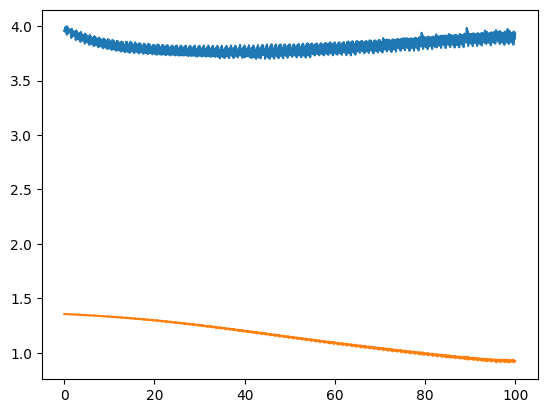

In [ ]:
plt.plot( np.linspace(0,epochs ,len(G_losses2)) ,np.array(G_losses2) )
plt.plot( np.linspace(0,epochs ,len(G_losses2)) ,np.array(D_losses2) )
plt.show()

In [ ]:
torch.save(generator2 , "/drive/My Drive/generator_withchroma" )
torch.save(discriminator2, "/drive/My Drive/discriminator_withchroma" )

jigs99.mid3


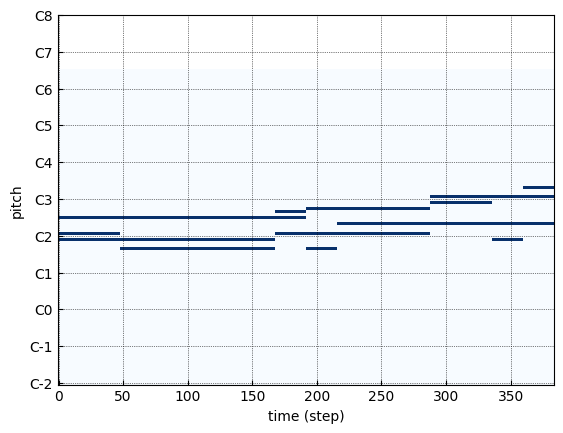

In [ ]:


result_array = generator2(input_test[9:9+1].to(device)).cpu().detach().numpy()

result_array = result_array[0,0,:16,:]



# for i in range(result_array.shape[0]):
#   result_array[i,result_array[i,:] != np.partition(result_array[i,:] , 3)] = 0
# result_array[result_array < 0.75] = 0

# result_array = pad_matrix(result_array)

result_array = filter_notes(result_array)
result_array = pad_matrix_o(result_array)

pp = pypianoroll.BinaryTrack(pianoroll = result_array)
pp.plot()

out = pypianoroll.Multitrack()
out.tempo = tempo_test[9]
out.append(pp)
pypianoroll.write("/drive/My Drive/test" + name_test[9]+ ".mid" , out)
print(name_test[9])

# Third Model using Polyphonic Rate Loss

In [ ]:
def polyphonic_rate(p_r, yes = 0.75, threshold = 3):
    """Return the ratio of the number of time steps where the number of pitches
    being played is larger than `threshold` to the total number of time steps"""

    non_negative_values = []
    nested_list = p_r.clone()
    nested_list[nested_list < yes] = 0
    nested_list[nested_list >= yes] = 1


    out = nested_list.sum(-1)
    out[out < threshold] = 0
    out[out >= threshold] = 1

    return torch.mean(out/nested_list.shape[2])

In [ ]:
generator3 = Generator(1).to(device)
generator3.apply(weights_init)

discriminator3 = Discriminator(1).to(device)
discriminator3.apply(weights_init);


In [ ]:
generator3 = torch.load("/drive/My Drive/generator_poly" )
discriminator3 = torch.load("/drive/My Drive/discriminator_poly" )

In [ ]:
class POLYLoss(nn.Module):
  def __init__(self):
        super(POLYLoss, self).__init__()

  def forward(self, output, target):
      
      return torch.abs(polyphonic_rate(output) -1)

In [ ]:

criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.
gen_criterion3 = POLYLoss()

# Setup Adam optimizers for both G and D
optimizerD3 = optim.Adam(discriminator3.parameters(), lr=rateD, betas=(adam_beta, 0.999))
optimizerG3 = optim.Adam(generator3.parameters(), lr=rate, betas=(adam_beta, 0.999))

In [ ]:
img_list = []
G_losses3 = []
D_losses3 = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(epochs):
    # For each batch in the dataloader
    for i, dataT in enumerate(zip(dataloader,dataloaderG), 0):
        data, dataG = dataT

        discriminator3.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        outputt = discriminator3(real_cpu).view(-1)

        errD_real = criterion(outputt, label)

        errD_real.backward()
        D_x = outputt.mean().item()

        inputt = dataG[0].to(device)

        fake = generator3(inputt)[:,:,:16,:88]


        label.fill_(fake_label)

        outputt = discriminator3(fake.detach()).view(-1)


        errD_fake = criterion(outputt, label)

        errD_fake.backward()
        D_G_z1 = outputt.mean().item()

        errD = errD_real + errD_fake

        optimizerD3.step()


        generator3.zero_grad()
        label.fill_(real_label)  
        outputt = discriminator3(fake).view(-1)

        errG = criterion(outputt, label) + gen_criterion3(fake,outputt) 
        
        errG.backward()
        D_G_z2 = outputt.mean().item()
        
        optimizerG3.step()


        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses3.append(errG.item())
        D_losses3.append(errD.item())

        iters += 1

Starting Training Loop...
[0/100][0/12]	Loss_D: 1.4016	Loss_G: 1.6162	D(x): 0.5352	D(G(z)): 0.5400 / 0.5400
[0/100][1/12]	Loss_D: 1.4017	Loss_G: 1.6163	D(x): 0.5351	D(G(z)): 0.5400 / 0.5400
[0/100][2/12]	Loss_D: 1.4016	Loss_G: 1.6162	D(x): 0.5352	D(G(z)): 0.5400 / 0.5400
[0/100][3/12]	Loss_D: 1.4014	Loss_G: 1.6161	D(x): 0.5354	D(G(z)): 0.5400 / 0.5400
[0/100][4/12]	Loss_D: 1.4014	Loss_G: 1.6161	D(x): 0.5354	D(G(z)): 0.5400 / 0.5400
[0/100][5/12]	Loss_D: 1.4013	Loss_G: 1.6161	D(x): 0.5355	D(G(z)): 0.5401 / 0.5401
[0/100][6/12]	Loss_D: 1.4017	Loss_G: 1.6162	D(x): 0.5352	D(G(z)): 0.5400 / 0.5400
[0/100][7/12]	Loss_D: 1.4013	Loss_G: 1.6163	D(x): 0.5353	D(G(z)): 0.5399 / 0.5399
[0/100][8/12]	Loss_D: 1.4009	Loss_G: 1.6162	D(x): 0.5356	D(G(z)): 0.5400 / 0.5400
[0/100][9/12]	Loss_D: 1.4012	Loss_G: 1.6162	D(x): 0.5355	D(G(z)): 0.5400 / 0.5400
[0/100][10/12]	Loss_D: 1.4010	Loss_G: 1.6162	D(x): 0.5355	D(G(z)): 0.5400 / 0.5400
[0/100][11/12]	Loss_D: 1.4018	Loss_G: 1.6161	D(x): 0.5352	D(G(z)): 0.54

In [ ]:
plt.plot( np.linspace(0,epochs ,len(G_losses3)) ,np.array(G_losses3) )
plt.plot( np.linspace(0,epochs ,len(G_losses3)) ,np.array(D_losses3) )
plt.show()

In [ ]:
torch.save(generator3 , "/drive/My Drive/generator_poly" )
torch.save(discriminator3, "/drive/My Drive/discriminator_poly" )

# Hybrid Model


In [ ]:
generator4 = Generator(1).to(device)
generator4.apply(weights_init)

discriminator4 = Discriminator(1).to(device)
discriminator4.apply(weights_init);


In [ ]:
generator4 = torch.load("/drive/My Drive/generator_hybridstep" )
discriminator4 = torch.load("/drive/My Drive/discriminator_hybridstep" )

In [ ]:
criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.
gen_criterion_hybrid1 = POLYLoss()
gen_criterion_hybrid2 = AnotherLoss()


# Setup Adam optimizers for both G and D
optimizerD4 = optim.Adam(discriminator4.parameters(), lr=rateD, betas=(adam_beta, 0.999))
optimizerG4 = optim.Adam(generator4.parameters(), lr=rate, betas=(adam_beta, 0.999))

In [ ]:
img_list = []
G_losses4 = []
D_losses4 = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(epochs):
    # For each batch in the dataloader
    for i, dataT in enumerate(zip(dataloader,dataloaderG), 0):
        data, dataG = dataT

        discriminator4.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        outputt = discriminator4(real_cpu).view(-1)

        errD_real = criterion(outputt, label)

        errD_real.backward()
        D_x = outputt.mean().item()

        inputt = dataG[0].to(device)

        fake = generator4(inputt)[:,:,:16,:88]


        label.fill_(fake_label)

        outputt = discriminator4(fake.detach()).view(-1)


        errD_fake = criterion(outputt, label)

        errD_fake.backward()
        D_G_z1 = outputt.mean().item()

        errD = errD_real + errD_fake

        optimizerD4.step()


        generator4.zero_grad()
        label.fill_(real_label)  
        outputt = discriminator4(fake).view(-1)

        errG = criterion(outputt, label) + gen_criterion_hybrid1(fake,outputt) + gen_criterion_hybrid2(fake,inputt) 
        
        errG.backward()
        D_G_z2 = outputt.mean().item()
        
        optimizerG4.step()


        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses4.append(errG.item())
        D_losses4.append(errD.item())

        iters += 1

Starting Training Loop...
[0/100][0/12]	Loss_D: 1.4040	Loss_G: 48.7184	D(x): 0.4958	D(G(z)): 0.5046 / 0.5046
[0/100][1/12]	Loss_D: 1.4041	Loss_G: 48.4684	D(x): 0.4957	D(G(z)): 0.5046 / 0.5046
[0/100][2/12]	Loss_D: 1.4045	Loss_G: 48.2860	D(x): 0.4956	D(G(z)): 0.5046 / 0.5046
[0/100][3/12]	Loss_D: 1.4054	Loss_G: 48.1081	D(x): 0.4951	D(G(z)): 0.5046 / 0.5045
[0/100][4/12]	Loss_D: 1.4041	Loss_G: 47.9408	D(x): 0.4958	D(G(z)): 0.5046 / 0.5046
[0/100][5/12]	Loss_D: 1.4041	Loss_G: 47.7649	D(x): 0.4957	D(G(z)): 0.5046 / 0.5045
[0/100][6/12]	Loss_D: 1.4033	Loss_G: 47.6569	D(x): 0.4962	D(G(z)): 0.5046 / 0.5046
[0/100][7/12]	Loss_D: 1.4041	Loss_G: 47.4960	D(x): 0.4957	D(G(z)): 0.5045 / 0.5045
[0/100][8/12]	Loss_D: 1.4037	Loss_G: 47.3735	D(x): 0.4959	D(G(z)): 0.5046 / 0.5046
[0/100][9/12]	Loss_D: 1.4032	Loss_G: 47.1930	D(x): 0.4962	D(G(z)): 0.5046 / 0.5046
[0/100][10/12]	Loss_D: 1.4015	Loss_G: 47.0196	D(x): 0.4971	D(G(z)): 0.5046 / 0.5046
[0/100][11/12]	Loss_D: 1.4025	Loss_G: 46.8469	D(x): 0.4965	D

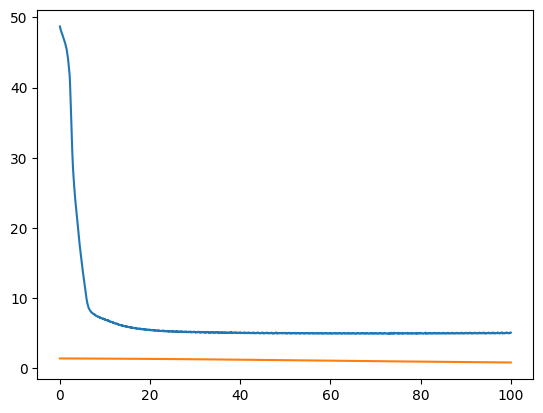

In [ ]:
plt.plot( np.linspace(0,epochs ,len(G_losses4)) ,np.array(G_losses4) )
plt.plot( np.linspace(0,epochs ,len(G_losses4)) ,np.array(D_losses4) )
plt.show()

In [ ]:
torch.save(generator4 , "/drive/My Drive/generator_hybrid" )
torch.save(discriminator4, "/drive/My Drive/discriminator_hybrid" )

reelsd-g72.mid3


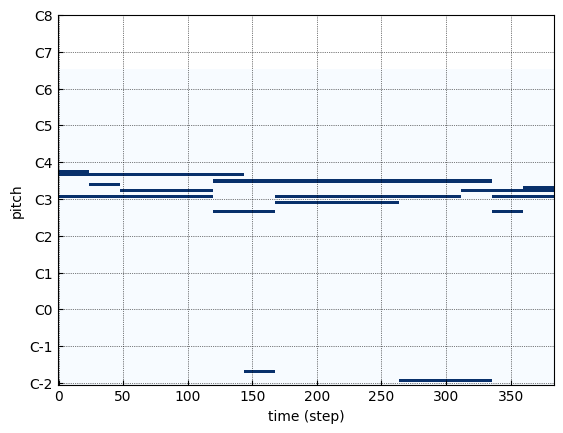

In [ ]:
result_array = generator4(input_test[10:10+1].to(device)).cpu().detach().numpy()

result_array = result_array[0,0,:16,:]



# for i in range(result_array.shape[0]):
#   result_array[i,result_array[i,:] != np.partition(result_array[i,:] , 3)] = 0
# result_array[result_array < 0.75] = 0

# result_array = pad_matrix(result_array)

result_array = filter_notes(result_array)
result_array = pad_matrix_o(result_array)

pp = pypianoroll.BinaryTrack(pianoroll = result_array)
pp.plot()

out = pypianoroll.Multitrack()
out.tempo = tempo_test[10]
out.append(pp)
pypianoroll.write("/drive/My Drive/test-hybrid" + name_test[10]+ ".mid" , out)
print(name_test[10])

D
reelsd-g72.mid3


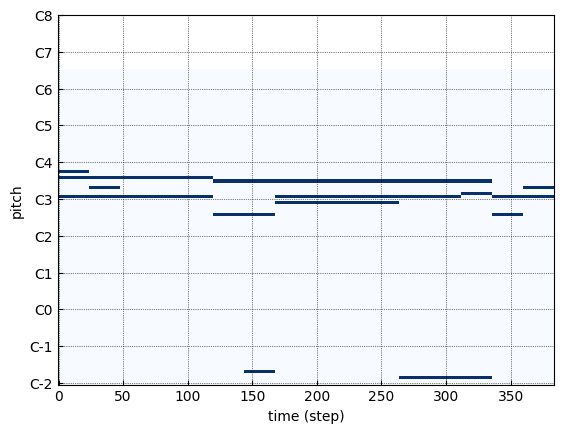

In [ ]:
result_array = post_process(result_array, keys_test[10])

pp = pypianoroll.BinaryTrack(pianoroll = result_array)
pp.plot()

out = pypianoroll.Multitrack()
out.tempo = tempo_test[10]
out.append(pp)
pypianoroll.write("/drive/My Drive/test-hybrid_proces" + name_test[10]+ ".mid" , out)
print(name_test[10])

# Hybrid Step Model


In [ ]:
generator5 = Generator(1).to(device)
generator5.apply(weights_init)

discriminator5 = Discriminator(1).to(device)
discriminator5.apply(weights_init);

In [ ]:
generator5 = torch.load("/drive/My Drive/generator_hybrid" )
discriminator5 = torch.load("/drive/My Drive/discriminator_hybrid" )

In [ ]:
criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.
gen_criterion_hybrid1 = POLYLoss()
gen_criterion_hybrid2 = AnotherLoss()


# Setup Adam optimizers for both G and D
optimizerD5 = optim.Adam(discriminator5.parameters(), lr=rateD, betas=(adam_beta, 0.999))
optimizerG5 = optim.Adam(generator5.parameters(), lr=rate, betas=(adam_beta, 0.999))

In [ ]:
img_list = []
G_losses5 = []
D_losses5 = []
iters = 0

epochs1 = 50
epochs2 = 50

print("Starting Training Loop 1...")
# For each epoch
for epoch in range(epochs1):
    # For each batch in the dataloader
    for i, dataT in enumerate(zip(dataloader,dataloaderG), 0):
        data, dataG = dataT

        discriminator5.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        outputt = discriminator5(real_cpu).view(-1)

        errD_real = criterion(outputt, label)

        errD_real.backward()
        D_x = outputt.mean().item()

        inputt = dataG[0].to(device)

        fake = generator5(inputt)[:,:,:16,:88]


        label.fill_(fake_label)

        outputt = discriminator5(fake.detach()).view(-1)


        errD_fake = criterion(outputt, label)

        errD_fake.backward()
        D_G_z1 = outputt.mean().item()

        errD = errD_real + errD_fake

        optimizerD5.step()


        generator5.zero_grad()
        label.fill_(real_label)  
        outputt = discriminator5(fake).view(-1)

        errG = criterion(outputt, label) + gen_criterion_hybrid1(fake,outputt) #+ gen_criterion_hybrid2(fake,inputt) 
        
        errG.backward()
        D_G_z2 = outputt.mean().item()
        
        optimizerG5.step()


        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs1, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses5.append(errG.item())
        D_losses5.append(errD.item())

        iters += 1

Starting Training Loop 1...
[0/50][0/12]	Loss_D: 1.3654	Loss_G: 1.7670	D(x): 0.4767	D(G(z)): 0.4644 / 0.4644
[0/50][1/12]	Loss_D: 1.3657	Loss_G: 1.7669	D(x): 0.4766	D(G(z)): 0.4644 / 0.4644
[0/50][2/12]	Loss_D: 1.3661	Loss_G: 1.7667	D(x): 0.4765	D(G(z)): 0.4645 / 0.4645
[0/50][3/12]	Loss_D: 1.3667	Loss_G: 1.7665	D(x): 0.4762	D(G(z)): 0.4647 / 0.4647
[0/50][4/12]	Loss_D: 1.3664	Loss_G: 1.7662	D(x): 0.4765	D(G(z)): 0.4648 / 0.4648
[0/50][5/12]	Loss_D: 1.3667	Loss_G: 1.7658	D(x): 0.4765	D(G(z)): 0.4649 / 0.4649
[0/50][6/12]	Loss_D: 1.3664	Loss_G: 1.7655	D(x): 0.4768	D(G(z)): 0.4651 / 0.4651
[0/50][7/12]	Loss_D: 1.3682	Loss_G: 1.7649	D(x): 0.4762	D(G(z)): 0.4654 / 0.4654
[0/50][8/12]	Loss_D: 1.3675	Loss_G: 1.7648	D(x): 0.4766	D(G(z)): 0.4655 / 0.4655
[0/50][9/12]	Loss_D: 1.3671	Loss_G: 1.7640	D(x): 0.4771	D(G(z)): 0.4658 / 0.4658
[0/50][10/12]	Loss_D: 1.3676	Loss_G: 1.7640	D(x): 0.4769	D(G(z)): 0.4658 / 0.4658
[0/50][11/12]	Loss_D: 1.3675	Loss_G: 1.7632	D(x): 0.4772	D(G(z)): 0.4662 / 0.466

In [ ]:
print("Starting Training Loop 2...")
# For each epoch
for epoch in range(epochs2):
    # For each batch in the dataloader
    for i, dataT in enumerate(zip(dataloader,dataloaderG), 0):
        data, dataG = dataT

        discriminator5.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        outputt = discriminator5(real_cpu).view(-1)

        errD_real = criterion(outputt, label)

        errD_real.backward()
        D_x = outputt.mean().item()

        inputt = dataG[0].to(device)

        fake = generator5(inputt)[:,:,:16,:88]


        label.fill_(fake_label)

        outputt = discriminator5(fake.detach()).view(-1)


        errD_fake = criterion(outputt, label)

        errD_fake.backward()
        D_G_z1 = outputt.mean().item()

        errD = errD_real + errD_fake

        optimizerD5.step()


        generator5.zero_grad()
        label.fill_(real_label)  
        outputt = discriminator5(fake).view(-1)

        errG = criterion(outputt, label) + gen_criterion_hybrid2(fake,inputt) 
        
        errG.backward()
        D_G_z2 = outputt.mean().item()
        
        optimizerG5.step()


        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs2, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses5.append(errG.item())
        D_losses5.append(errD.item())

        iters += 1

Starting Training Loop 2...
[0/50][0/12]	Loss_D: 1.4246	Loss_G: 9.0080	D(x): 0.4793	D(G(z)): 0.4978 / 0.4977
[0/50][1/12]	Loss_D: 1.3841	Loss_G: 7.8284	D(x): 0.4792	D(G(z)): 0.4770 / 0.4769
[0/50][2/12]	Loss_D: 1.3798	Loss_G: 6.4716	D(x): 0.4790	D(G(z)): 0.4746 / 0.4745
[0/50][3/12]	Loss_D: 1.3746	Loss_G: 6.5842	D(x): 0.4791	D(G(z)): 0.4719 / 0.4719
[0/50][4/12]	Loss_D: 1.3795	Loss_G: 5.1950	D(x): 0.4791	D(G(z)): 0.4745 / 0.4744
[0/50][5/12]	Loss_D: 1.3770	Loss_G: 5.1936	D(x): 0.4789	D(G(z)): 0.4730 / 0.4730
[0/50][6/12]	Loss_D: 1.3771	Loss_G: 4.9298	D(x): 0.4792	D(G(z)): 0.4733 / 0.4733
[0/50][7/12]	Loss_D: 1.3774	Loss_G: 4.8712	D(x): 0.4785	D(G(z)): 0.4728 / 0.4727
[0/50][8/12]	Loss_D: 1.3776	Loss_G: 4.8635	D(x): 0.4789	D(G(z)): 0.4734 / 0.4733
[0/50][9/12]	Loss_D: 1.3758	Loss_G: 4.7501	D(x): 0.4796	D(G(z)): 0.4731 / 0.4731
[0/50][10/12]	Loss_D: 1.3769	Loss_G: 4.7400	D(x): 0.4788	D(G(z)): 0.4728 / 0.4728
[0/50][11/12]	Loss_D: 1.3738	Loss_G: 4.6382	D(x): 0.4795	D(G(z)): 0.4719 / 0.471

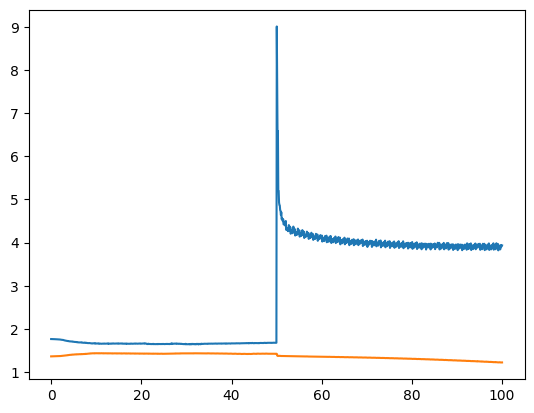

In [ ]:
plt.plot( np.linspace(0,epochs ,len(G_losses5)) ,np.array(G_losses5) )
plt.plot( np.linspace(0,epochs ,len(G_losses5)) ,np.array(D_losses5) )
plt.show()

In [ ]:
torch.save(generator5 , "/drive/My Drive/generator_hybridstep" )
torch.save(discriminator5, "/drive/My Drive/discriminator_hybridstep" )

reelsd-g72.mid3


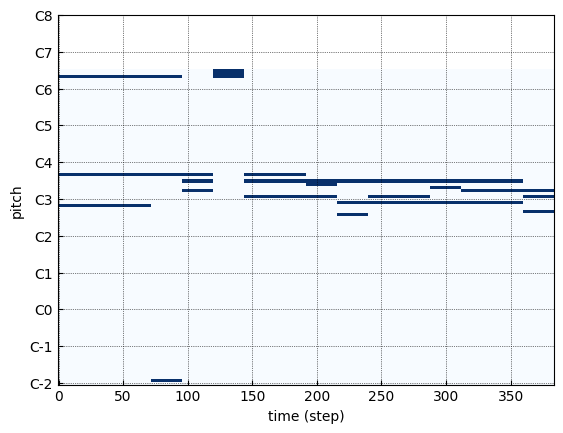

In [ ]:
result_array = generator5(input_test[10:10+1].to(device)).cpu().detach().numpy()

result_array = result_array[0,0,:16,:]



# for i in range(result_array.shape[0]):
#   result_array[i,result_array[i,:] != np.partition(result_array[i,:] , 3)] = 0
# result_array[result_array < 0.75] = 0

# result_array = pad_matrix(result_array)

result_array = filter_notes(result_array)
result_array = pad_matrix_o(result_array)

pp = pypianoroll.BinaryTrack(pianoroll = result_array)
pp.plot()

out = pypianoroll.Multitrack()
out.tempo = tempo_test[10]
out.append(pp)
pypianoroll.write("/drive/My Drive/test-hybrid_step" + name_test[10]+ ".mid" , out)
print(name_test[10])

D
reelsd-g72.mid3


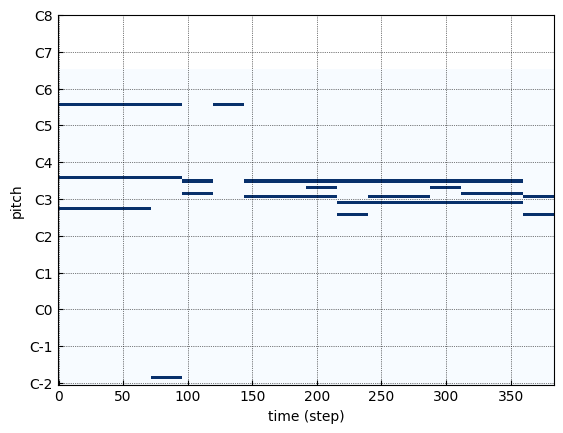

In [ ]:
result_array = post_process(result_array, keys_test[10])

pp = pypianoroll.BinaryTrack(pianoroll = result_array)
pp.plot()

out = pypianoroll.Multitrack()
out.tempo = tempo_test[10]
out.append(pp)
pypianoroll.write("/drive/My Drive/test-hybrid_step_proces" + name_test[10]+ ".mid" , out)
print(name_test[10])

# N Pitches Used Model

In [ ]:
generator6 = torch.load("/drive/My Drive/generator_npitches" )
discriminator6 = torch.load("/drive/My Drive/discriminator_npitches" )
alpha = 0.01

In [ ]:
def n_pitches_used(matrix):
    # Check that the matrix has the correct dimensions
    
    # Reshape the matrix to have 4 bars per row
    matrix = filter_notes_batch(matrix)
    reshaped_matrix = matrix.reshape((matrix.shape[0],4, 4, 88))
    
    # Compute the number of unique pitches used per bar
    
    unique_pitches = torch.sum(torch.count_nonzero(reshaped_matrix, axis=-1), axis=-2 , dtype = torch.float)
    
    # Return the average number of unique pitches used per bar
    return torch.mean(unique_pitches)

In [ ]:
class PitchLoss(nn.Module):
  def __init__(self):
        super(PitchLoss, self).__init__()

  def forward(self, output, target):
      
      return  alpha * n_pitches_used(output)

# Post Processing

In [ ]:
import heapq

indices = []
def print_indices_greater_than_zero(matrix):
    for row in matrix:
        temp = [i for i, x in enumerate(row) if x > 0]
        indices.append(temp)
    return indices

def nth_smallest(matrix, n):
    # Flatten the matrix into a list
    flat_matrix = [elem for row in matrix for elem in row]
    
    # Use a heap to find the nth smallest element
    nth_smallest = heapq.nsmallest(n, flat_matrix)[-1]
    
    return nth_smallest

temp = print_indices_greater_than_zero(result_array)
print(nth_smallest(temp, 100))


In [ ]:
def post_process_other(matrix, key, input):
    print(key)
    root = [0,2,4, 5,7,9,11, 12,14,16, 17,19,21,23, 24,26,28, 29,31,33,35, 36,38,40, 41,43,45,47, 48,50,52, 53,55,57,59, 60,62,64, 65,67,69,71, 72,74,76, 77,79,81,83, 84,86]
    root = np.array(root)
    keys_dict = {
        "C": root,"Am": root,
        "C#": np.add(root,1), "A#m": np.add(root,1), "Db": np.add(root,1),"Bbm": np.add(root,1),
        "D": np.add(root,2), "Bm": np.add(root,2),
        "D#": np.add(root,3), "B#m": np.add(root,3),
        "Eb": np.add(root,3), "Cm": np.add(root,3),
        "E": np.add(root,4), "C#m": np.add(root,4),
        "F": np.add(root,5), "Dm": np.add(root,5),
        "F#": np.add(root,6), "D#m": np.add(root,6), "Gb": np.add(root,6), "Ebm": np.add(root,6),
        "G": np.add(root,7), "Em": np.add(root,7),
        "G#": np.add(root,8), "Ab": np.add(root,8), "Fm": np.add(root,8),
        "A": np.add(root,9), "F#m": np.add(root,9),
        "A#": np.add(root,10), "Bb": np.add(root,10), "Gm": np.add(root,10),
        "B": np.add(root,11), "G#m": np.add(root,11),
        }
    matrix[:,:20] = 0
    scale = keys_dict[key].copy()
    num_rows, num_cols = matrix.shape
    mask = []
    banned = []

    for row in range(num_rows):
        for i in range(num_cols):
            #print(i)
            if matrix[row][i] > 0:
                #print(i)
                if i not in scale:
                    #print("hi")
                    closest_value = None
                    min_distance = float('inf')

                    for val in scale:
                        distance = abs(val - i)

                        if distance < min_distance:
                            min_distance = distance
                            closest_value = val

                    matrix[row][closest_value] = matrix[row][i]
                    mask.append(i)
                    scale = [x for x in scale if x not in mask]
                    matrix[row][i] = 0
    
    for i in range(num_rows):
      invalid = []
      for j in range(num_cols):
        if(matrix[i,j] > 0):
          if(j in invalid):
            matrix[i,j] = 0
          else:
            for k in range(0,10):
              invalid.append(j+(k*12)+1)
              invalid.append(j+(k*12)-1)
      banned.append(invalid)

    for i in range(num_rows):
      invalid = banned[i]
      for j in range(num_cols):
        if(matrix[i,j] > 0):
          if(j in invalid):
            matrix[i,j] = 0
            distance_1 = 0
            for val in scale:
              if(val <= j):
                continue
              else:
                distance_1 = val%88
            matrix[i,distance_1] = 1
          else:
            for k in range(0,10):
              invalid.append(j+(k*12)+11)
              invalid.append(j+(k*12)-11)
    
    for i in range(num_rows):
      invalid = banned[i]
      for j in range(num_cols):
        if(matrix[i,j] > 0):
          if(j in invalid):
            matrix[i,j] = 0
            distance_1 = 0
            for val in scale:
              if(val <= j):
                continue
              else:
                distance_1 = val%88
            matrix[i,distance_1] = 1
          else:
            for k in range(0,10):
              invalid.append(j+(k*12)+2)
              invalid.append(j+(k*12)-2)



    for i in range(num_rows):
      invalid = banned[i]
      for j in range(num_cols):
        if(input[i,j] > 0):
          for k in range(0,10):
              invalid.append(j+(k*12)+1)
              invalid.append(j+(k*12)+2)
              invalid.append(j+(k*12)+11)
              invalid.append(j+(k*12)-1)
              invalid.append(j+(k*12)-2)
              invalid.append(j+(k*12)-11)
          if(j in invalid):
            if(matrix[i,j] > 0):
              matrix[i,j] = 0
              distance_1 = 0
              for val in scale:
                if(val <= j):
                  continue
                else:
                  distance_1 = val% 88
              matrix[i,distance_1] = 1
    matrix[:,:20] = 0

    return matrix


In [ ]:
def post_process(matrix, key, input):
    print(key)
    root = [0,2,4, 5,7,9,11, 12,14,16, 17,19,21,23, 24,26,28, 29,31,33,35, 36,38,40, 41,43,45,47, 48,50,52, 53,55,57,59, 60,62,64, 65,67,69,71, 72,74,76, 77,79,81,83, 84,86,88, 89]
    root = np.array(root)
    keys_dict = {
        "C": root,"Am": root,
        "C#": np.add(root,1), "A#m": np.add(root,1), "Db": np.add(root,1),"Bbm": np.add(root,1),
        "D": np.add(root,2), "Bm": np.add(root,2),
        "D#": np.add(root,3), "B#m": np.add(root,3),
        "Eb": np.add(root,3), "Cm": np.add(root,3),
        "E": np.add(root,4), "C#m": np.add(root,4),
        "F": np.add(root,5), "Dm": np.add(root,5),
        "F#": np.add(root,6), "D#m": np.add(root,6), "Gb": np.add(root,6), "Ebm": np.add(root,6),
        "G": np.add(root,7), "Em": np.add(root,7),
        "G#": np.add(root,8), "Ab": np.add(root,8), "Fm": np.add(root,8),
        "A": np.add(root,9), "F#m": np.add(root,9),
        "A#": np.add(root,10), "Bb": np.add(root,10), "Gm": np.add(root,10),
        "B": np.add(root,11), "G#m": np.add(root,11),
        }
    
    matrix[:,:20] = 0
    scale = keys_dict[key].copy()
    num_rows, num_cols = matrix.shape
    mask = []
    banned = []

    # Modify minor 2nds
    for row in range(num_rows):
        for i in range(num_cols - 1):
            if matrix[row][i] > 0 and matrix[row][i+1] > 0:
                min_distance_1 = float('inf')
                min_distance_2 = float('inf')

                for val in scale:
                    distance_1 = abs(val - i)
                    distance_2 = abs(val - i+1)

                    if distance_1 < min_distance_1:
                        min_distance_1 = distance_1

                    if distance_2 < min_distance_2:
                        min_distance_2 = distance_2

                if min_distance_2 <= min_distance_1:
                    mask.append(i)
                    scale = [x for x in scale if x not in mask]
                    
                    matrix[row][i] = 0
                else:
                    mask.append(i+1)
                    scale = [x for x in scale if x not in mask]
                    matrix[row][i+1] = 0

        banned.append(scale) 
        scale = keys_dict[key].copy()
    
    # Modify notes that are not part of key to fit the key
    for row in range(num_rows):
        for i in range(num_cols):
            #print(i)
            if matrix[row][i] > 0:
                #print(i)
                if i not in scale:
                    #print("hi")
                    closest_value = None
                    min_distance = float('inf')

                    for val in scale:
                        distance = abs(val - i)

                        if distance < min_distance:
                            min_distance = distance
                            closest_value = val

                    matrix[row][closest_value] = matrix[row][i]
                    mask.append(i)
                    scale = [x for x in scale if x not in mask]
                    matrix[row][i] = 0

    

    # Modify Major 7ths                
    for row in range(num_rows):
        for i in range(num_cols - 11):
            if matrix[row][i] > 0 and matrix[row][i+11] > 0:
                min_distance_1 = float('inf')
                min_distance_2 = float('inf')

                for val in scale:
                    distance_1 = abs(val - i)
                    distance_2 = abs(val - i+1)

                    if distance_1 < min_distance_1:
                        min_distance_1 = distance_1

                    if distance_2 < min_distance_2:
                        min_distance_2 = distance_2

                if min_distance_2 <= min_distance_1:
                    mask.append(i)
                    matrix[row][i] = 0
                else:
                    mask.append(i+11)
                    matrix[row][i+11] = 0

    scale = [x for x in scale if x not in mask]
                    
    #Modify Major 2nds                
    for row in range(num_rows):
        for i in range(num_cols - 2):
            if matrix[row][i] > 0 and matrix[row][i+2] > 0:
                min_distance_1 = float('inf')
                min_distance_2 = float('inf')

                for val in scale:
                    distance_1 = abs(val - i)
                    distance_2 = abs(val - i+1)

                    if distance_1 < min_distance_1:
                        min_distance_1 = distance_1

                    if distance_2 < min_distance_2:
                        min_distance_2 = distance_2

                if min_distance_2 <= min_distance_1:
                    mask.append(i)
                    matrix[row][i] = 0
                else:
                    mask.append(i+2)
                    matrix[row][i+2] = 0

    scale = [x for x in scale if x not in mask]

    # Modify minor 2nds
    for row in range(num_rows):
        for i in range(num_cols - 1):
            if matrix[row][i] > 0 and matrix[row][i+1] > 0:
                min_distance_1 = float('inf')
                min_distance_2 = float('inf')

                for val in scale:
                    distance_1 = abs(val - i)
                    distance_2 = abs(val - i+1)

                    if distance_1 < min_distance_1:
                        min_distance_1 = distance_1

                    if distance_2 < min_distance_2:
                        min_distance_2 = distance_2

                if min_distance_2 <= min_distance_1:
                    mask.append(i)
                    matrix[row][i] = 0
                else:
                    mask.append(i+1)
                    matrix[row][i+1] = 0

    scale = [x for x in scale if x not in mask]

# MODIFYING DISSONANCE WITH INPUT NOW

    # Modify minor 2nds
    for row in range(num_rows):
        for i in range(num_cols - 1):
            if matrix[row][i] > 0 and input[row][i+1] > 0:
                min_distance_1 = float('inf')
                min_distance_2 = float('inf')

                for val in scale:
                    distance_1 = abs(val - i)
                    distance_2 = abs(val - i+1)

                    if distance_1 < min_distance_1:
                        min_distance_1 = distance_1

                    if distance_2 < min_distance_2:
                        min_distance_2 = distance_2

                if min_distance_2 <= min_distance_1:
                    mask.append(i)
                    matrix[row][i] = 0
                else:
                    mask.append(i+1)
                    matrix[row][i+1] = 0

    scale = [x for x in scale if x not in mask]

    # Modify Major 7ths                
    for row in range(num_rows):
        for i in range(num_cols - 11):
            if matrix[row][i] > 0 and input[row][i+11] > 0:
                min_distance_1 = float('inf')
                min_distance_2 = float('inf')

                for val in scale:
                    distance_1 = abs(val - i)
                    distance_2 = abs(val - i+1)

                    if distance_1 < min_distance_1:
                        min_distance_1 = distance_1

                    if distance_2 < min_distance_2:
                        min_distance_2 = distance_2

                if min_distance_2 <= min_distance_1:
                    mask.append(i)
                    matrix[row][i] = 0
                else:
                    mask.append(i+11)
                    matrix[row][i+11] = 0

    scale = [x for x in scale if x not in mask]
                    
    #Modify Major 2nds                
    for row in range(num_rows):
        for i in range(num_cols - 2):
            if matrix[row][i] > 0 and input[row][i+2] > 0:
                min_distance_1 = float('inf')
                min_distance_2 = float('inf')

                for val in scale:
                    distance_1 = abs(val - i)
                    distance_2 = abs(val - i+1)

                    if distance_1 < min_distance_1:
                        min_distance_1 = distance_1

                    if distance_2 < min_distance_2:
                        min_distance_2 = distance_2

                if min_distance_2 <= min_distance_1:
                    mask.append(i)
                    matrix[row][i] = 0
                else:
                    mask.append(i+2)
                    matrix[row][i+2] = 0

    scale = [x for x in scale if x not in mask]

    # Modify minor 2nds
    for row in range(num_rows):
        for i in range(num_cols - 1):
            if matrix[row][i] > 0 and input[row][i+1] > 0:
                min_distance_1 = float('inf')
                min_distance_2 = float('inf')

                for val in scale:
                    distance_1 = abs(val - i)
                    distance_2 = abs(val - i+1)

                    if distance_1 < min_distance_1:
                        min_distance_1 = distance_1

                    if distance_2 < min_distance_2:
                        min_distance_2 = distance_2

                if min_distance_2 <= min_distance_1:
                    mask.append(i)
                    matrix[row][i] = 0
                else:
                    mask.append(i+1)
                    matrix[row][i+1] = 0

    scale = [x for x in scale if x not in mask]

# MODIFYING DISSONANCE WITH INPUT NOW

    return matrix

reelsd-g72.mid3


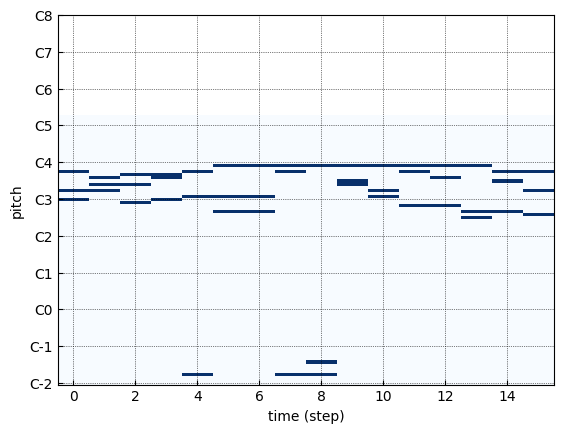

In [ ]:
idx = 10
result_array = generator3(input_test[idx:idx+1].to(device)).cpu().detach().numpy()

result_array = result_array[0,0,:16,:88]



# for i in range(result_array.shape[0]):
#   result_array[i,result_array[i,:] != np.partition(result_array[i,:] , 3)] = 0
# result_array[result_array < 0.75] = 0

# result_array = pad_matrix(result_array)

result_array = filter_notes(result_array)
#result_array = pad_matrix_o(result_array)

pp = pypianoroll.BinaryTrack(pianoroll = result_array)
pp.plot()

out = pypianoroll.Multitrack()
out.tempo = tempo_test[idx]
out.append(pp)
pypianoroll.write("/drive/My Drive/test-poly" + name_test[idx]+ ".mid" , out)
print(name_test[idx])

1
(16, 88)
reelsd-g72.mid3


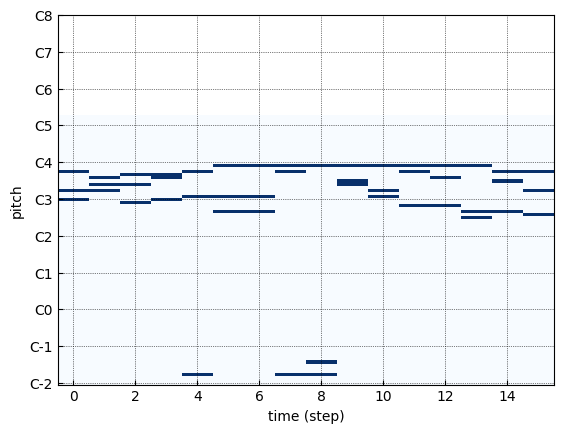

In [ ]:
print(len(input_test[idx]))
print(result_array.shape)
#result_array = post_process(result_array, keys_test[idx], input_test[idx])

pp = pypianoroll.BinaryTrack(pianoroll = result_array)
pp.plot()

out = pypianoroll.Multitrack()
out.tempo = tempo_test[idx]
out.append(pp)
pypianoroll.write("/drive/My Drive/test-poly_proces" + name_test[idx]+ ".mid" , out)
print(name_test[idx])

# **Comparing Model Performance**

In [ ]:
def filter_notes_batch(matrix):
    # Get the number of rows in the matrix
    matrix = matrix.detach().cpu().numpy()
    num_rows = matrix.shape[2]
    
    # Create a new matrix filled with zeros to store the output
    output_matrix = np.zeros_like(matrix)
    
    # Loop over each row of the input matrix
    for i in range(matrix.shape[0]):
      for j in range(num_rows):
          # Get the current row of the matrix
          row = matrix[i,0,j, :]
          
          # Find the indices of the 3 largest values in the row
          indices = np.argpartition(row, -3)[-3:]
          
          # Set all elements in the row to 0 except for the 3 largest values
          row[row < row[indices].min()] = 0
          
          # Assign the modified row to the corresponding row in the output matrix
          output_matrix[i,0,j, :] = row
    output_matrix[output_matrix > 0] = 1
    return torch.FloatTensor(output_matrix)

In [ ]:
input_test = input_test.to(device)

In [ ]:
def chroma_loss_test(gen , test_base):
  return chroma_loss(gen(test_base)[:,:,:16,:88] , test_base)

In [ ]:
ChromaticLoss = []

ChromaticLoss.append(chroma_loss_test(generator , input_test).detach().cpu().numpy())
ChromaticLoss.append(chroma_loss_test(generator2 , input_test).detach().cpu().numpy())
ChromaticLoss.append(chroma_loss_test(generator3 , input_test).detach().cpu().numpy())
ChromaticLoss.append(chroma_loss_test(generator4 , input_test).detach().cpu().numpy())
ChromaticLoss.append(chroma_loss_test(generator5 , input_test).detach().cpu().numpy())
ChromaticLoss.append(chroma_loss_test(generator6 , input_test).detach().cpu().numpy())

print(np.array(ChromaticLoss))

[  7.692542    2.9270184   8.148676    3.132914    3.0800943 563.1512   ]


In [ ]:
def polyphonic_rate_t(p_r, yes = 0.75, threshold = 3):
    """Return the ratio of the number of time steps where the number of pitches
    being played is larger than `threshold` to the total number of time steps"""

    non_negative_values = []
    nested_list = p_r.clone()
    nested_list = filter_notes_batch(nested_list)



    out = nested_list.sum(-1)
    out[out < threshold] = 0
    out[out >= threshold] = 1

    return torch.abs(torch.mean(out/nested_list.shape[2]) - 1)

In [ ]:
def polyphonic_rate_test(gen , test_base):
  return polyphonic_rate_t(gen(test_base)[:,:,:16,:88])

In [ ]:
PolyPhonicLoss = []

PolyPhonicLoss.append(polyphonic_rate_test(generator , input_test).detach().cpu().numpy())
PolyPhonicLoss.append(polyphonic_rate_test(generator2 , input_test).detach().cpu().numpy())
PolyPhonicLoss.append(polyphonic_rate_test(generator3 , input_test).detach().cpu().numpy())
PolyPhonicLoss.append(polyphonic_rate_test(generator4 , input_test).detach().cpu().numpy())
PolyPhonicLoss.append(polyphonic_rate_test(generator5 , input_test).detach().cpu().numpy())
PolyPhonicLoss.append(polyphonic_rate_test(generator6 , input_test).detach().cpu().numpy())

print(np.array(PolyPhonicLoss))

[0.93793726 0.9383745  0.9473133  0.94074106 0.9383745  1.        ]


In [ ]:
def n_pitches_used_test(gen , test_base):
  return n_pitches_used(gen(test_base)[:,:,:16,:88])

In [ ]:
NPitchesLoss = []

NPitchesLoss.append(n_pitches_used_test(generator , input_test).detach().cpu().numpy())
NPitchesLoss.append(n_pitches_used_test(generator2 , input_test).detach().cpu().numpy())
NPitchesLoss.append(n_pitches_used_test(generator3 , input_test).detach().cpu().numpy())
NPitchesLoss.append(n_pitches_used_test(generator4 , input_test).detach().cpu().numpy())
NPitchesLoss.append(n_pitches_used_test(generator5 , input_test).detach().cpu().numpy())
NPitchesLoss.append(n_pitches_used_test(generator6 , input_test).detach().cpu().numpy())

print(np.array(NPitchesLoss))

[12.074627 12.00831  12.019505 12.141112 13.135685 22.861092]


In [ ]:
AllLoss = np.zeros((3,6))
AllLoss[0,:] = np.array(ChromaticLoss)
AllLoss[1,:] = np.array(PolyPhonicLoss)
AllLoss[2,:] = np.array(NPitchesLoss)

GeneralLoss = AllLoss.mean(0)
print(GeneralLoss)

[  6.90170209   5.29123441   7.03849792   5.40492249   5.71805127
 195.67075857]


In [8]:
ChromaticLoss = np.array([  7.692542   , 2.9270184 ,  8.148676 ,   3.132914  ,  3.0800943  ,563.1512   ])
PolyPhonicLoss = np.array([ 0.93793726, 0.9383745 , 0.9473133 , 0.94074106 , 0.9383745  , 1.        ])
NPitchesLoss = np.array([ 12.074627 ,12.00831 , 12.019505 , 12.141112 ,13.135685 , 22.861092])
GeneralLoss = np.array([   6.90170209 ,  5.29123441 ,  7.03849792 ,   5.40492249  , 5.71805127 ,195.67075857   ])


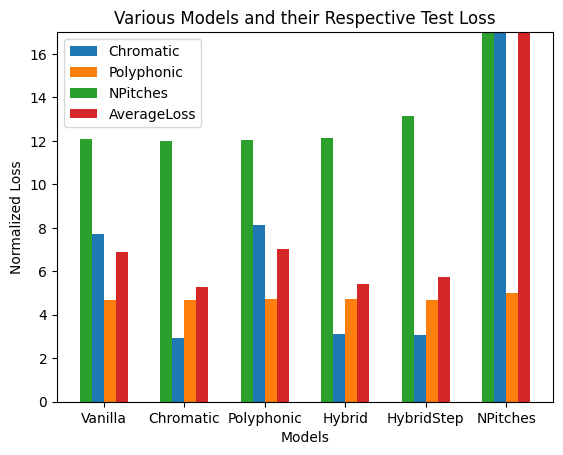

In [10]:
categories = ["Vanilla" , "Chromatic" , "Polyphonic" , "Hybrid" ,"HybridStep" , "NPitches"]
models = np.arange(len(categories))
width = 0.15

plt.bar(models - width/2, np.array(ChromaticLoss), width)
plt.bar(models + width/2, np.array(PolyPhonicLoss)*5, width)
plt.bar(models - width*1.5, np.array(NPitchesLoss), width)
plt.bar(models + width*1.5, np.array(GeneralLoss), width)

plt.xlabel('Models')
plt.ylabel('Normalized Loss')
plt.xticks(models, categories)
plt.ylim(ymax = 17, ymin = 0)
plt.title("Various Models and their Respective Test Loss")
plt.legend(['Chromatic', 'Polyphonic' , 'NPitches', 'AverageLoss'])



plt.show()

# **Generating Outputs Model**

In [ ]:
musescore = []

musescore = os.listdir("/drive/My Drive/musescore")
print(len(musescore))

#DATA PROCESSING
tempo_muse = []
input_muse = []
output_muse = []
name_muse = []
keys_muse = []

for path in musescore:
    midi = pypianoroll.read('/drive/My Drive/musescore/' + path)
    mid = mido.MidiFile('/drive/My Drive/musescore/' + path, clip=True)
    #print(vocal)
    vocal = midi.tracks[0]
    piano = midi.tracks[1]
    vocal.binarize()
    vocalpr = shrink_matrix(vocal.pianoroll[:,22:110])
    piano.binarize()
    pianopr = shrink_matrix_o(piano.pianoroll[:,22:110])
    for i in range(len(vocalpr) // 64):
      new_matrix = vocalpr[i*64:(i+1)*64,:]/80
      input_muse.append(new_matrix)
      new_matrix = pianopr[i*16:(i+1)*16, :]/80
      output_muse.append(new_matrix)
      tempo_muse.append(midi.tempo)
      name_muse.append(path + str(i))
      keys_muse.append(find_key(mid))

print(len(output_muse))

59


/usr/local/lib/python3.9/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


1052


In [ ]:
input_muse = np.array(input_muse)
output_muse = np.array(output_muse)
name_muse = np.array(name_muse)
tempo_muse = np.array(tempo_muse)
keys_muse = np.array(keys_muse)

input_muse = input_muse[:,np.newaxis , :]
output_muse = output_muse[:, np.newaxis,:]


output_muse = torch.Tensor(output_muse)
input_muse = torch.Tensor(input_muse)

<ipython-input-19-5abecfcd85cf>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tempo_muse = np.array(tempo_muse)


In [ ]:
print(output_muse.shape)

torch.Size([1052, 1, 16, 88])


In [ ]:
generated_music = generator2(input_muse.to(device))

In [ ]:
result_array = generated_music.cpu().detach().numpy()

result_array = result_array[:,0,:16,:88]

for i , a in enumerate(result_array):
  a = filter_notes(a)
  a = post_process(a, keys_muse[i], input_muse[i])
  a = pad_matrix_o(a)
  pp = pypianoroll.BinaryTrack(pianoroll = a)
  out = pypianoroll.Multitrack()
  out.tempo = tempo_muse[i]
  out.append(pp)
  pypianoroll.write("/drive/My Drive/muse_output/" + name_muse[i]+ ".mid" , out)
  print(name_muse[i])



In [ ]:
generated_music2 = generator4(input_muse.to(device))

In [ ]:
songswewant = ["All of Me", "Canon_in_D",  "As_the_Deer" , "mary" , "Someone_like_You" , "Stay"]

In [ ]:
def pad_rests_matrix(matrix):
  for i in range(matrix.shape[0]):
    if i % 24 == 0:
      matrix[i,:] = 0
  return matrix

In [ ]:
def pad_for_post(matrix):
  new_matrix = np.empty((0, matrix.shape[1]), matrix.dtype)
  for row in matrix:
    for i in range(4):
      new_matrix = np.vstack((new_matrix, row))
    
  return new_matrix

In [ ]:
result_array = generated_music2.cpu().detach().numpy()

result_array = result_array[:,0,:16,:88]

for i , a in enumerate(result_array):
  if( songswewant[1] in name_muse[i] ):
    a = filter_notes(a)
    a = pad_for_post(a)
    a = post_process(a, keys_muse[i] , input_muse[i,0,:,:])
    a = pad_matrix(a)
    a = pad_rests_matrix(a)
    pp = pypianoroll.BinaryTrack(pianoroll = a)
    pp.plot()
    out = pypianoroll.Multitrack()
    out.tempo = tempo_muse[i]
    out.append(pp)
    pypianoroll.write("/drive/My Drive/new_muse/" + name_muse[i]+ ".mid" , out)
    print(name_muse[i])

D
As_the_Deer_-_Piano_and_Voice.mid0
D
As_the_Deer_-_Piano_and_Voice.mid1
D
As_the_Deer_-_Piano_and_Voice.mid2
D
As_the_Deer_-_Piano_and_Voice.mid3
D
As_the_Deer_-_Piano_and_Voice.mid4


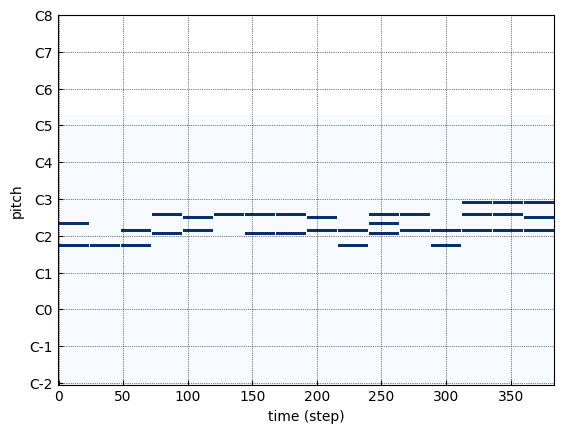

In [ ]:
result_array = generated_music2.cpu().detach().numpy()

result_array = result_array[:,0,:16,:88]

for i , a in enumerate(result_array):
  if( songswewant[2] in name_muse[i] ):
    a = filter_notes(a)
    a = pad_for_post(a)
    a = post_process_other(a, keys_muse[i] , input_muse[i,0,:,:])
    a = pad_matrix(a)
    a = pad_rests_matrix(a)
    pp = pypianoroll.BinaryTrack(pianoroll = a)
    pp.plot()
    out = pypianoroll.Multitrack()
    out.tempo = tempo_muse[i]
    out.append(pp)
    pypianoroll.write("/drive/My Drive/as_the_deer" + name_muse[i]+ ".mid" , out)
    print(name_muse[i])

In [4]:
!pip install onnx
import onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 21.7 MB/s eta 0:00:00


In [6]:
dummy_input_G = torch.randn(10, 1, 64, 88, device=device)
dummy_input_O = torch.randn(10, 1, 16, 88, device=device)

torch.onnx.export(generator, dummy_input_G, "generator.onnx")
torch.onnx.export(discriminator, dummy_input_O, "discriminator.onnx")


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

